In [46]:
%%time
import os
import traceback
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
import xgboost as xgb
import seaborn as sns




user='hifld_summer'
pw='hifld_summer'
name='hifld_summer'
host='moria'
port=2023
engine = sqlalchemy.create_engine(
    f'postgresql://{user}:{pw}@{host}:{port}/{name}'
    )

CPU times: total: 0 ns
Wall time: 1 ms


In [2]:
%%time
"MODEL SET-UP"
"Loading in the data from the database"

sql ="""
select * from results.all_features_w_class
"""
df = pd.read_sql_query(sql, con=engine)

CPU times: total: 56.7 s
Wall time: 1min 11s


In [5]:
df.columns

Index(['new_sqmeters', 'perimeter', 'vertex_count', 'length', 'width',
       'long_side', 'short_side', 'ls_ratio', 'pp_compactness',
       'min_bounding_circle_area', 'reock_compactness', 'sch_compactness',
       'lon', 'lat', 'points_in_polygon_buffers', 'ls_ratios_mean',
       'ls_ratios_std', 'ls_ratios_min', 'ls_ratios_max', 'area_mean',
       'area_std', 'area_min', 'area_max', 'mh_flag'],
      dtype='object')

In [4]:
%%time
"Dropping unnecessary columns (leaving only features and label) and setting index"

df = df.drop(columns=['geom', 'use_code_std_lps', 'use_code_std_desc_lps', 'parcel_lid', 'build_id', 'prim_occ'])

df.set_index('uuid', inplace=True)

CPU times: total: 672 ms
Wall time: 678 ms


In [6]:
df.head(2)

,new_sqmeters,perimeter,vertex_count,length,width,long_side,short_side,ls_ratio,pp_compactness,min_bounding_circle_area,...,points_in_polygon_buffers,ls_ratios_mean,ls_ratios_std,ls_ratios_min,ls_ratios_max,area_mean,area_std,area_min,area_max,mh_flag
uuid,,,,,,,,,,,,,,,,,,,,,
{41d5cadc-9dfb-4286-8c95-679ddc040416},505.712776,109.244544,6,38.737520,25.867066,38.73752,25.867066,1.497561,0.532493,1318.869211,...,14,1.184490,0.180276,1.011278,1.497561,195.826218,135.620522,42.908956,505.712776,0
{41d5cfec-707c-4d24-867e-a158aa450156},98.069987,57.020126,6,19.236482,19.350590,19.35059,19.236482,1.005932,0.379044,416.036078,...,5,1.587689,0.606463,1.005932,2.334468,165.185151,83.271834,98.069987,294.207192,0


In [7]:
%%time
"Seperating dataframe into x (features) and y (label)"

X = df.drop(columns=['mh_flag'], axis=1)
y = df['mh_flag']

CPU times: total: 156 ms
Wall time: 168 ms


In [8]:
%%time
"Checking for class imbalance"

df.mh_flag.value_counts(normalize=True)

CPU times: total: 31.2 ms
Wall time: 26 ms


mh_flag
0    0.932338
1    0.067662
Name: proportion, dtype: float64

In [9]:
%%time
"Splitting into training and testing datasets"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

CPU times: total: 3.77 s
Wall time: 3.77 s


In [10]:
%%time
"Standardizing training set and applying the standardization to the training set"

sc = StandardScaler()
sc.fit(X_train)

X_train_scaled = sc.transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

CPU times: total: 766 ms
Wall time: 761 ms


In [11]:
%%time
"Saving the standard scaler"

dump(sc, 'my_standard_scaler.pkl')

CPU times: total: 0 ns
Wall time: 5.45 ms


['my_standard_scaler.pkl']

In [12]:
%%time
"Loading the standard scaler back"

same_scaler = load('my_standard_scaler.pkl')

CPU times: total: 0 ns
Wall time: 0 ns


In [13]:
%%time
"Applying the standardization to the testing set"


X_test_scaled = same_scaler.transform(X_test)

X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

CPU times: total: 141 ms
Wall time: 144 ms


In [14]:
"-----CLASSIFICATION MODELS---------------------------------------------------------------------------------------------------------------------------"

'-----CLASSIFICATION MODELS---------------------------------------------------------------------------------------------------------------------------'

In [15]:
%%time
"LINEAR CLASSIFER (BASELINE MODEL)"

base_lr = LogisticRegression(random_state = 42, max_iter=1000)

CPU times: total: 0 ns
Wall time: 0 ns


In [16]:
%%time
"Fitting linear classifier"

base_lr.fit(X_train, y_train)

CPU times: total: 1min 26s
Wall time: 22.5 s


LogisticRegression(max_iter=1000, random_state=42)

In [17]:
%%time
"Using the trained linear classifier to predict on the testing set"

base_lr_predict = base_lr.predict(X_test)

CPU times: total: 250 ms
Wall time: 131 ms


In [18]:
%%time
"Checking validity of the linear classifier's output"

base_lr_predict

CPU times: total: 0 ns
Wall time: 0 ns


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [23]:
%%time
"Creating a confusion matrix for the linear classifier"

lr_cmatrix = confusion_matrix(y_test, base_lr_predict)
print(lr_cmatrix)

[[764183     85]
 [ 55462      2]]
CPU times: total: 188 ms
Wall time: 190 ms


In [24]:
%%time
"Creating a classification report for the linear classifier"

print(classification_report(y_test, base_lr_predict))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96    764268
           1       0.02      0.00      0.00     55464

    accuracy                           0.93    819732
   macro avg       0.48      0.50      0.48    819732
weighted avg       0.87      0.93      0.90    819732

CPU times: total: 1.59 s
Wall time: 1.58 s


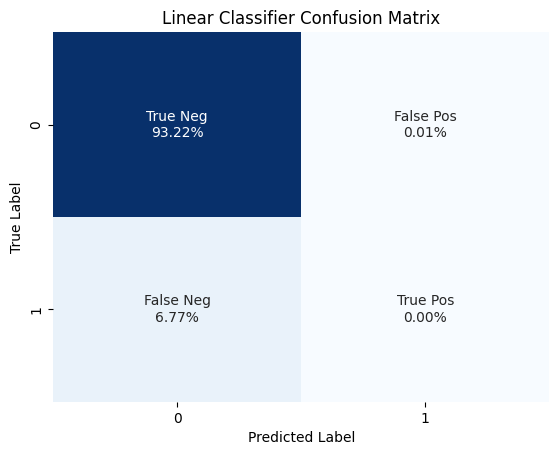

CPU times: total: 125 ms
Wall time: 111 ms


In [48]:
%%time
"Creating a heatmap for the linear classifier's confusion matrix"

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     lr_cmatrix.flatten()/np.sum(lr_cmatrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lr_cmatrix, annot=labels, fmt='', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Linear Classifier Confusion Matrix')

plt.show()

In [49]:
%%time
"DECISION TREE CLASSIFIER"

base_dt = DecisionTreeClassifier(random_state = 42)

CPU times: total: 0 ns
Wall time: 0 ns


In [50]:
%%time
"Fitting decision tree"

base_dt.fit(X_train, y_train)

CPU times: total: 2min 21s
Wall time: 2min 21s


DecisionTreeClassifier(random_state=42)

In [51]:
%%time
"Using the trained decision tree to predict on the testing set"

base_dt_predict = base_dt.predict(X_test)

CPU times: total: 500 ms
Wall time: 498 ms


In [52]:
%%time
"Checking validity of the decision tree's output"

base_dt_predict

CPU times: total: 0 ns
Wall time: 0 ns


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [53]:
%%time
"Creating a confusion matrix for the decision tree"

dt_cmatrix = confusion_matrix(y_test, base_dt_predict)
print(dt_cmatrix)

[[717514  46754]
 [ 40340  15124]]
CPU times: total: 172 ms
Wall time: 172 ms


In [54]:
%%time
"Creating a classification report for the decision tree"

print(classification_report(y_test, base_dt_predict))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94    764268
           1       0.24      0.27      0.26     55464

    accuracy                           0.89    819732
   macro avg       0.60      0.61      0.60    819732
weighted avg       0.90      0.89      0.90    819732

CPU times: total: 1.7 s
Wall time: 1.72 s


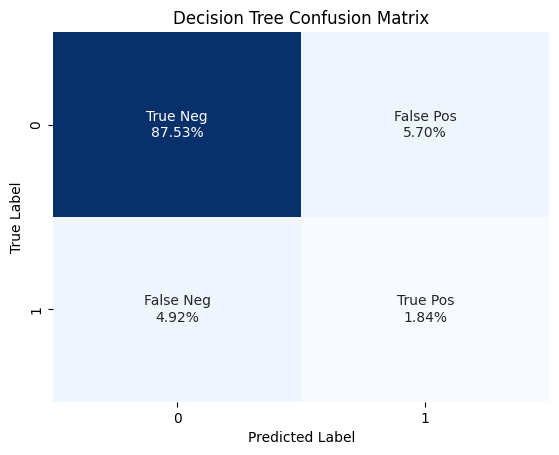

CPU times: total: 109 ms
Wall time: 117 ms


In [55]:
%%time
"Creating a heatmap for the linear classifier's confusion matrix"

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     dt_cmatrix.flatten()/np.sum(dt_cmatrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(dt_cmatrix, annot=labels, fmt='', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Decision Tree Confusion Matrix')

plt.show()

In [56]:
%%time
"RANDOM FOREST CLASSIFIER"

base_rf = RandomForestClassifier(max_depth = 2, random_state = 42)

CPU times: total: 0 ns
Wall time: 0 ns


In [57]:
%%time
"Fitting random forest"

base_rf.fit(X_train, y_train)

CPU times: total: 4min 27s
Wall time: 4min 28s


RandomForestClassifier(max_depth=2, random_state=42)

In [58]:
%%time
"Using the trained random forest to predict on the testing set"

base_rf_predict = base_rf.predict(X_test)

CPU times: total: 4.67 s
Wall time: 4.67 s


In [59]:
%%time
"Checking validity of the random forest's output"

base_rf_predict

CPU times: total: 0 ns
Wall time: 0 ns


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [60]:
%%time
"Creating a confusion matrix for the random forest"

rf_cmatrix = confusion_matrix(y_test, base_rf_predict)
print(rf_cmatrix)

[[764268      0]
 [ 55464      0]]
CPU times: total: 219 ms
Wall time: 201 ms


In [61]:
%%time
"Creating a classification report for the random forest"

print(classification_report(y_test, base_rf_predict))

C:\Users\zsn\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zsn\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.93      1.00      0.96    764268
           1       0.00      0.00      0.00     55464

    accuracy                           0.93    819732
   macro avg       0.47      0.50      0.48    819732
weighted avg       0.87      0.93      0.90    819732

CPU times: total: 1.52 s
Wall time: 1.53 s


C:\Users\zsn\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


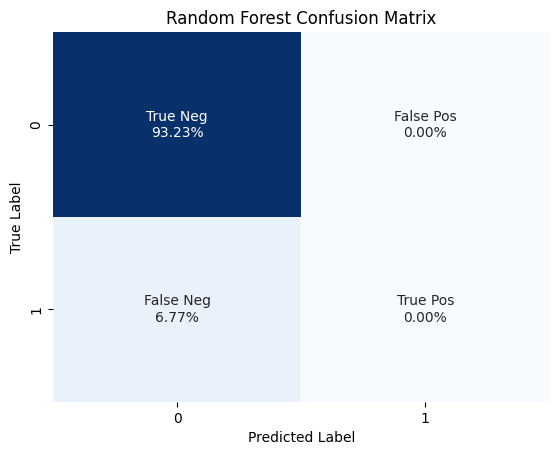

CPU times: total: 109 ms
Wall time: 105 ms


In [62]:
%%time
"Creating a heatmap for the random forest's confusion matrix"

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     rf_cmatrix.flatten()/np.sum(rf_cmatrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(rf_cmatrix, annot=labels, fmt='', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')

plt.show()

In [63]:
%%time
"XGBOOST CLASSIFIER"

base_xg = xgb.XGBClassifier(max_depth=2)

CPU times: total: 0 ns
Wall time: 0 ns


In [64]:
%%time
"Fitting random forest"

base_xg.fit(X_train, y_train)

CPU times: total: 45.9 s
Wall time: 8.03 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [65]:
%%time
"Using the trained random forest to predict on the testing set"

base_xg_predict = base_xg.predict(X_test)

CPU times: total: 1.34 s
Wall time: 206 ms


In [66]:
%%time
"Checking validity of the random forest's output"

base_xg_predict

CPU times: total: 0 ns
Wall time: 0 ns


array([0, 0, 0, ..., 0, 0, 0])

In [67]:
%%time
"Creating a confusion matrix for the random forest"

xg_cmatrix = confusion_matrix(y_test, base_xg_predict)
print(xg_cmatrix)

[[763426    842]
 [ 54307   1157]]
CPU times: total: 172 ms
Wall time: 173 ms


In [68]:
%%time
"Creating a classification report for the random forest"

print(classification_report(y_test, base_xg_predict))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97    764268
           1       0.58      0.02      0.04     55464

    accuracy                           0.93    819732
   macro avg       0.76      0.51      0.50    819732
weighted avg       0.91      0.93      0.90    819732

CPU times: total: 1.44 s
Wall time: 1.45 s


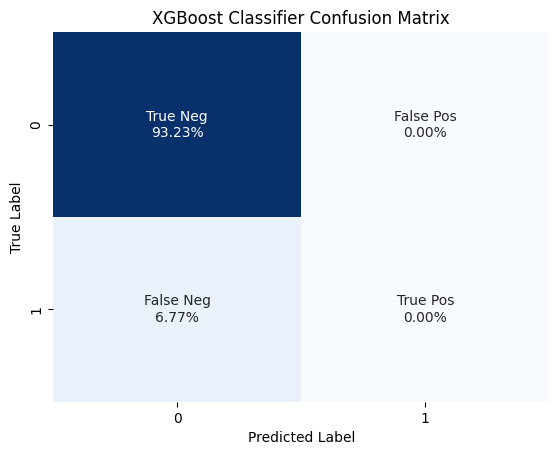

CPU times: total: 125 ms
Wall time: 120 ms


In [69]:
%%time
"Creating a heatmap for the XGBoost classifier's confusion matrix"

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     rf_cmatrix.flatten()/np.sum(rf_cmatrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(rf_cmatrix, annot=labels, fmt='', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Classifier Confusion Matrix')

plt.show()